#Multi Agent for Academic Books
Made by: Wilfredo Aaron Sosa Ramos

In [10]:
!pip install -q langchain langchain_core langchain_community langgraph langchain_google_genai

In [12]:
import os
from google.colab import userdata

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = userdata.get(var)

_set_if_undefined("SERPER_API_KEY")
_set_if_undefined("GOOGLE_API_KEY")

In [13]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_core.tools import tool

@tool
def serper_tool(
    query: Annotated[str, "The search query for retrieving intermediate answers."]
):
    """Use this to perform a search query using the Google Serper API.
    Provide a concise query to retrieve relevant information."""
    try:
        search = GoogleSerperAPIWrapper()
        result = search.run(query)
    except BaseException as e:
        return f"Failed to execute search. Error: {repr(e)}"

    result_str = f"Successfully executed search:\nQuery: {query}\nResult: {result}"
    return (
        result_str
    )

In [16]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a specialized AI assistant focused on researching, analyzing, and summarizing knowledge from books and academic literature. "
        "Your goal is to collaborate with tools and other assistants to locate and process information using APIs such as SerperAPI. "
        "Retrieve accurate, well-cited information, and ensure your findings are relevant and trustworthy. "
        "Deliver the following outputs: "
        "- Critical summaries of the content, emphasizing key concepts, insights, and implications. "
        "- Valid URLs or references to original sources, where applicable. "
        "If you are unable to retrieve complete information, document your progress and provide sufficient context so another assistant can continue the task seamlessly. "
        "When all deliverables are complete, prefix your response with 'FINAL ANSWER' to signal the task is finalized and ready for review."
        f"\n{suffix}"
    )

In [15]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

In [17]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")

def get_next_node(last_message: BaseMessage, goto: str):
    if goto == "FINAL ANSWER":
        # Any agent decided the work is done
        return END
    return goto

In [18]:
serper_research_agent = create_react_agent(
    llm,
    tools=[serper_tool],
    state_modifier = make_system_prompt(
        """You are an expert in retrieving and analyzing knowledge from books and academic literature. Your goal is to locate real, reliable information and provide valid references or URLs, when applicable, based on a given research topic. Utilize APIs like SerperAPI to ensure accurate and trustworthy results. Deliver critical summaries and ensure your findings are presented in a clear and concise manner."""
    )
)

In [23]:
from langchain.schema import (
       AIMessage,
       HumanMessage,
       SystemMessage
  )

def web_search_node(state: MessagesState, agent_name: str, agent) -> Command[Literal["format_results"]]:
    """
    A generic node handler for research agents to avoid repetition and improve maintainability.

    Args:
        state: The current state of the messages.
        agent: The research agent's `invoke` method.
        agent_name: The name of the research agent (e.g., "tavily", "serper").

    Returns:
        A Command object with updated messages and the next node to transition to.
    """
    result = agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "format_results")

    # Update the last message with the agent's name
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name=agent_name
    )

    print(f"WEB SEARCH NODE: {result['messages'][-1].content}")

    return Command(
        update={
            "messages": result["messages"],  # Share internal message history with other agents
        },
        goto=goto,
    )


def serper_node(state: MessagesState) -> Command[Literal["format_results"]]:
    return web_search_node(state, "serper", serper_research_agent)

In [33]:
from pydantic import BaseModel, Field, validator

class AnswerSchema(BaseModel):
    summary: str = Field(..., description="A concise and high-level summary of the answer to the question.")
    detailed_explanation: str = Field(
        ...,
        description="An in-depth explanation, including analysis, reasoning, and supporting evidence."
    )
    key_takeaways: list[str] = Field(
        ...,
        description="A list of actionable or significant points derived from the research."
    )

class QAResearchResult(BaseModel):
    question: str = Field(..., description="The research question or query provided by the user.")
    answer: AnswerSchema = Field(..., description="A structured response to the research question, divided into components.")
    topic: str = Field(..., description="The broader academic topic or context related to the question.")
    sources: list[str] = Field(
        ...,
        min_items=1,
        description="A non-empty list of references or titles of the books, papers, or resources used to answer the question. Must have at least one value."
    )
    source_urls: list[str] = Field(
        ...,
        min_items=1,
        description="A non-empty list of real and valid URLs pointing to the resources used for the answer. Must have at least one value."
    )
    detailed_analysis: str = Field(
        ...,
        description="A comprehensive analysis of the resources, including their methodology, key findings, and implications."
    )
    related_keywords: list[str] = Field(
        ...,
        description="A list of relevant keywords or topics extracted from the question and the analyzed resources."
    )
    confidence_score: float = Field(
        ...,
        description="The confidence score of the provided answer, ranging from 0 to 1."
    )
    tools_used: list[str] = Field(
        ...,
        description="A list of tools or APIs used to retrieve, analyze, or synthesize the information."
    )
    citation_format: str = Field(
        ...,
        description="The format used for citations (e.g., APA, MLA, Chicago)."
    )
    citations: list[str] = Field(
        ...,
        description="A list of citations for the resources used, formatted according to the specified citation format."
    )
    retrieval_date: str = Field(
        ...,
        description="The date when the information was retrieved in YYYY-MM-DD format."
    )
    response_time: float = Field(
        ...,
        description="The time taken to generate the response, in seconds."
    )

    @validator("sources", "source_urls")
    def must_have_min_items(cls, value):
        if len(value) < 1:
            raise ValueError("This field must have at least one value.")
        return value


<ipython-input-33-147d5fcf880e>:61: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  @validator("sources", "source_urls")


In [34]:
from langchain_core.output_parsers import JsonOutputParser

def format_results(state: MessagesState) -> Command[Literal[END]]:
    json_parser = JsonOutputParser(pydantic_object=QAResearchResult)

    messages = [
        SystemMessage(
            content=(
                "You are a QA-focused AI assistant tasked with answering questions based on real information retrieved from the web. "
                "Your responses must adhere to the `QAResearchResult` schema and provide accurate, structured, and well-cited information. "
                "Ensure that the `sources` and `source_urls` fields in your response are non-empty, valid, and reliable."
            )
        ),
        HumanMessage(
            content=f"""Answer the following question based on the retrieved information and format the response using the `QAResearchResult` schema:

            Question: {state['messages'][0].content}
            Web Context: {state['messages'][-1].content}

            Ensure your response adheres to the following schema fields:
            - `question`: The original question asked by the user.
            - `answer`: A structured response that includes:
                - `summary`: A concise, high-level summary of the answer.
                - `detailed_explanation`: A thorough explanation based on the retrieved information.
                - `key_takeaways`: A list of actionable or significant points derived from the answer.
            - `topic`: The broader academic topic or context related to the question.
            - `sources`: A non-empty list of references or titles of the books, papers, or resources used to answer the question.
            - `source_urls`: A non-empty list of real and valid URLs pointing to the resources used for the answer.
            - `detailed_analysis`: A comprehensive analysis of the sources used, including methodology, key findings, and implications.
            - `related_keywords`: A list of relevant keywords or topics extracted from the question and the analyzed resources.
            - `confidence_score`: A score between 0 and 1 indicating the confidence level of the answer.
            - `tools_used`: A list of tools or APIs utilized to retrieve and analyze the information.
            - `citation_format`: The format used for citations (e.g., APA, MLA, Chicago).
            - `citations`: A list of properly formatted citations for the resources used.
            - `retrieval_date`: The date when the information was retrieved (YYYY-MM-DD).
            - `response_time`: The time taken to generate the response, in seconds.

            You must respond in the language of the user's question.

            Use the following JSON format for your response:
            {json_parser.get_format_instructions()}
            """
        )
    ]

    result = llm.invoke(messages)
    goto = get_next_node(result, "FINAL ANSWER")

    # Update the last message with the agent's name
    result = HumanMessage(
        content=result.content, name="format_results"
    )

    print(f"FORMAT RESULT: {result.content}")

    return Command(
        update={
            "messages": result,
        },
        goto=goto,
    )

In [35]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("serper_node", serper_node)
workflow.add_node("format_results", format_results)

workflow.add_edge(START, "serper_node")
graph = workflow.compile()

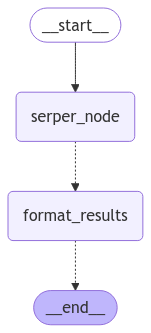

In [31]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [36]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "What are the insights from the LLM Engineer's Handbook Book?"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

WEB SEARCH NODE: The "LLM Engineer's Handbook" appears to be a practical guide focused on the end-to-end process of working with Large Language Models (LLMs). Here are some key insights gleaned from the search results:

**Key Concepts & Insights:**

*   **Practical Application:** The book emphasizes practical application of LLMs in real-world scenarios, moving beyond theoretical concepts.
*   **MLOps Best Practices:** It leverages MLOps (Machine Learning Operations) best practices for designing, training, and deploying LLMs. This suggests a focus on efficiency, scalability, and maintainability.
*   **End-to-End System Development:** The book guides readers through the entire process of creating LLM-based systems, including data collection and generation, training pipelines, and deployment.
*   **Broad Coverage:** It covers a wide range of topics, including training, Retrieval-Augmented Generation (RAG), evaluations, and fine-tuning, suggesting a comprehensive approach to LLM engineerin

In [37]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "¿Cuáles son los puntos más importantes del libro '¿Cómo hacer una tesis?' de Humberto Eco?"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

WEB SEARCH NODE: Según la información recuperada, los puntos principales del libro "¿Cómo se hace una tesis?" de Umberto Eco son:

*   **Selección del tema:** El tema de la tesis debe ser concreto y corresponder a los intereses del doctorando, estando relacionado con sus estudios, lecturas y mundo personal.
*   **Recopilación de documentos:** Es crucial recopilar documentos relevantes y de fácil acceso que respalden la investigación. Se debe recurrir a ediciones originales y confiables.
*   **Organización de la información:** Los documentos recopilados deben organizarse de manera lógica para facilitar el análisis y la construcción de argumentos.
*   **Análisis y examen del tema:** El tema debe ser examinado a profundidad, identificando ideas clave y desarrollando reflexiones propias.
*   **Estructura de la tesis:** El libro proporciona orientación sobre cómo estructurar el trabajo de investigación, incluyendo la organización del tiempo, la búsqueda bibliográfica y la presentación final

In [38]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "¿De qué trata este Paper? https://www.scielo.org.mx/pdf/ap/v39n2/2448-735X-ap-39-02-7.pdf"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

WEB SEARCH NODE: The paper "Análisis del concepto de calidad de vida en el campo de la salud: una revisión de la literatura" (Analysis of the concept of quality of life in the field of health: a literature review) discusses the increasing use of the concept of quality of life in health evaluations and as a measure of well-being. It highlights that despite its frequent use, there isn't a universally agreed-upon definition. The paper aims to analyze the conceptual and theoretical aspects of quality of life and its contributions across different disciplines. It also touches upon the definition of Health-Related Quality of Life (HRQoL), which stems from the WHO's 1948 definition of health as a state of complete physical, mental, and social well-being. The review emphasizes that quality of life is a fundamental concept in health-related activities, yet it lacks a clear and unified definition.

The paper also mentions that quality of life generally refers to the conditions that make life ple